In [2]:
import pandas as pd


customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Display basic information about each dataset
customers_info = customers.info()
products_info = products.info()
transactions_info = transactions.info()

# Display the first few rows of each dataset
customers_head = customers.head()
products_head = products.head()
transactions_head = transactions.head()

customers_info, customers_head, products_info, products_head, transactions_info, transactions_head



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  


(None,
   CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
 None,
   ProductID              ProductName     Category   Price
 0      P001     ActiveWear Biography        Books  169.30
 1      P002    ActiveWear Smartwatch  Electronics  346.30
 2      P003  ComfortLiving Biography        Books   44.12
 3      P004            BookWorld Rug   Home Decor   95.69
 4      P005          TechPro T-Shirt     Clothing  429.31,
 None,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  20

C:\Users\abupa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\abupa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\abupa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\abupa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

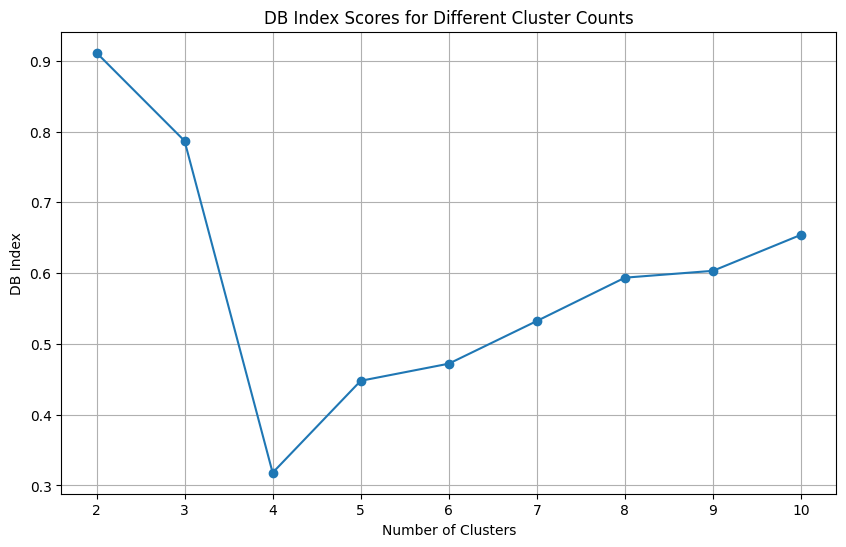

(4, 0.31803826553950526)

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Combine Customers.csv and Transactions.csv for clustering
customer_transactions = transactions.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total spending
    "Quantity": "sum"     # Total quantity purchased
}).reset_index()

customer_data = customers.merge(customer_transactions, on="CustomerID", how="left").fillna(0)

# Encode categorical variables (Region)
customer_data_encoded = pd.get_dummies(customer_data, columns=["Region"])

# Normalize numerical columns
numerical_features = ["TotalValue", "Quantity"]
scaler = MinMaxScaler()
customer_data_encoded[numerical_features] = scaler.fit_transform(customer_data_encoded[numerical_features])

# Prepare features for clustering
features = customer_data_encoded.drop(columns=["CustomerID", "CustomerName", "SignupDate"])

# Apply K-Means with different cluster counts (2 to 10) and calculate DB Index
db_index_scores = {}
kmeans_models = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features)
    db_index = davies_bouldin_score(features, labels)
    db_index_scores[k] = db_index
    kmeans_models[k] = kmeans

# Find the best cluster count based on the lowest DB Index
optimal_clusters = min(db_index_scores, key=db_index_scores.get)
best_kmeans = kmeans_models[optimal_clusters]

# Add cluster labels to customer data
customer_data["Cluster"] = best_kmeans.labels_

# Visualize the DB Index scores
plt.figure(figsize=(10, 6))
plt.plot(list(db_index_scores.keys()), list(db_index_scores.values()), marker='o')
plt.title("DB Index Scores for Different Cluster Counts")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.xticks(range(2, 11))
plt.grid()
plt.show()

optimal_clusters, db_index_scores[optimal_clusters]


In [4]:
# Check the first few rows of the customer data with clusters
customer_data.head()


,CustomerID,CustomerName,Region,SignupDate,TotalValue,Quantity,Cluster
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,12.0,1
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,10.0,3
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,14.0,1
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,23.0,1
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,7.0,3


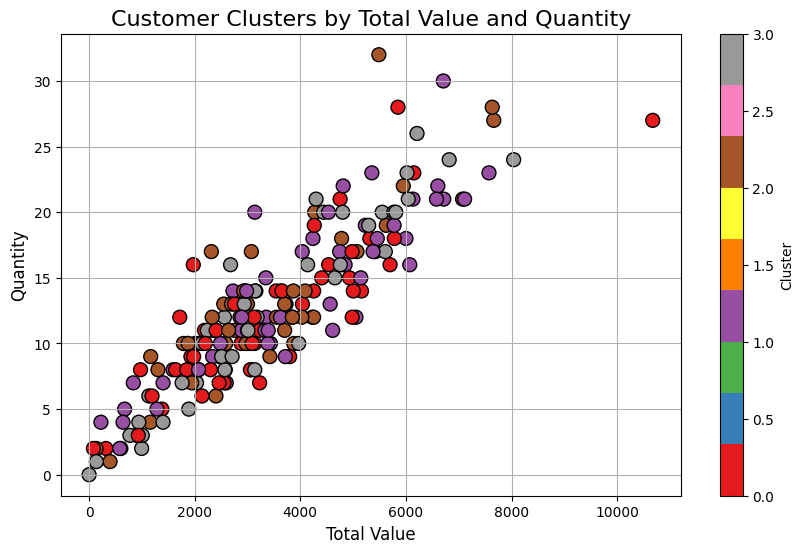

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(
    customer_data["TotalValue"], 
    customer_data["Quantity"], 
    c=customer_data["Cluster"], 
    cmap='Set1', 
    s=100, 
    edgecolor='black'
)
plt.title("Customer Clusters by Total Value and Quantity", fontsize=16)
plt.xlabel("Total Value", fontsize=12)
plt.ylabel("Quantity", fontsize=12)
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


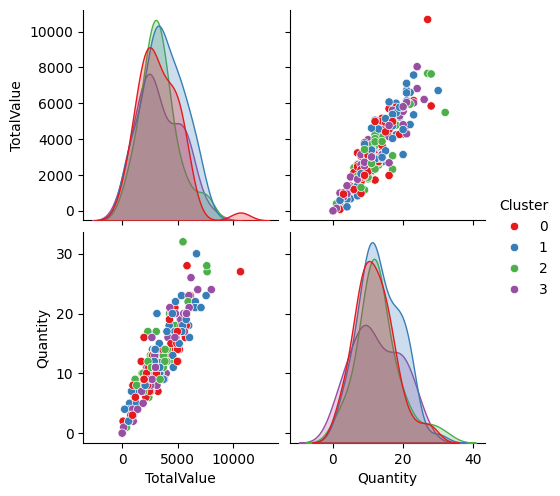

In [6]:
import seaborn as sns

sns.pairplot(customer_data, hue='Cluster', palette='Set1', diag_kind='kde')
plt.show()


In [7]:
# Group by clusters and calculate the mean or median for each cluster
cluster_summary = customer_data.groupby("Cluster").agg({
    "TotalValue": ['mean', 'median'],
    "Quantity": ['mean', 'median'],
    # Add other columns you want to analyze, e.g., Region or other encoded features
})

print(cluster_summary)


          TotalValue            Quantity       
                mean   median       mean median
Cluster                                        
0        3325.092600  3106.59  11.900000   11.0
1        3717.840000  3434.77  13.372881   12.0
2        3311.160870  3034.21  12.891304   12.0
3        3379.443778  3009.29  12.444444   11.0
